Download and extract data.


In [1]:
# remove all files present
!rm -rfv ./*
#download dataset
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri" -O Data.zip && rm -rf /tmp/cookies.txt
# unzip
!unzip -q Data.zip
# remove zip 
!rm -rf ./Data.zip


removed './sample_data/README.md'
removed './sample_data/anscombe.json'
removed './sample_data/mnist_test.csv'
removed './sample_data/california_housing_test.csv'
removed './sample_data/mnist_train_small.csv'
removed './sample_data/california_housing_train.csv'
removed directory './sample_data'
--2020-08-08 15:18:07--  https://docs.google.com/uc?export=download&confirm=pK2E&id=1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri
Resolving docs.google.com (docs.google.com)... 74.125.142.139, 74.125.142.101, 74.125.142.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-0s-docs.googleusercontent.com/docs/securesc/9seq1gai02icrr8sgn5d8bm6gvl5dnrh/ermn2vq0n7mlb9cis68ibq1sir105rcu/1596899850000/07496480791912752493/09709114075345369774Z/1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri?e=download [following]
--2020-08-08 15:18:07--  https://doc-10-0s-docs.googleusercontent.com/docs/securesc/9seq1gai02

In [2]:
# code block 1
# import
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
print(tf.__version__)
tf.random.set_seed(12345)
import glob

2.3.0


In [3]:
# code block 2
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE
Batch_Size = 128 #batch size used in the code.
KNeghb = 6 #Number to top N images needed.
PATHS = glob.glob('./dataset/*.jpg')
IMG_SHAPE = (224,224,3)
print(PATHS[:5])

def decode_image(filename, label=None, image_size=IMG_SHAPE[:-1]):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    return image

dataset = (
    tf.data.Dataset
    .from_tensor_slices(PATHS)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(Batch_Size)
)

['./dataset/1130.jpg', './dataset/2821.jpg', './dataset/4550.jpg', './dataset/1188.jpg', './dataset/4733.jpg']


Till now we have downloaded created the datapipeline now we should proceed with the problem that is finding similar N images.


# Finding similar N images.

The main theme is to extract feature from the images and then use them to find the similar images.

To tackel this problem we would like to use transfer learning first as it seems a easy solution and will help to get results quicker. 

In [4]:
#code block 3
# we use mobile net as lightweigth model.
model = tf.keras.applications.MobileNet( input_shape=IMG_SHAPE,include_top=False, weights='imagenet')
#model.summary()
print("Model Loaded !")
output_shape_model = tuple([int(x) for x in model.output.shape[1:]])
print(f"The Output shape is {output_shape_model}")
shape_img_resize = tuple([int(x) for x in model.input.shape[1:]])

print(f"The image size is {shape_img_resize}")

17227776/17225924 [==============================] - 0s 0us/step
Model Loaded !
The Output shape is (7, 7, 1024)
The image size is (224, 224, 3)


In [5]:
# run it only once
import h5py
import numpy as np
import os
from tqdm import tqdm

def save_prediction(dataset,model):
  path = './out.h5'
  if not os.path.exists(path):
    with h5py.File(path, "x") as f:
      flag = True
      dset = f.create_dataset('Feature_map',(Batch_Size,np.prod(output_shape_model)),
                              maxshape=(None,np.prod(output_shape_model)),
                              chunks=(Batch_Size,np.prod(output_shape_model)))
      for element in tqdm(dataset,ascii = True, desc = "Dataset"):
        predict  = model.predict(element)
        #print(predict.shape)
        flat_pred = predict.reshape((-1,np.prod(output_shape_model)))
        #print(flat_pred.shape)
        if flag:
          dset[:] = flat_pred       
          #print(dset.shape)
          flag = False
          # (100000,)
        else:
          dset.resize(dset.shape[0]+flat_pred.shape[0], axis=0)   
          dset[-flat_pred.shape[0]:] = flat_pred
          #print(dset.shape)
      f.close

save_prediction(dataset,model)
##
# at the end of this the ram still gets occupied because of this issue:
# https://github.com/h5py/h5py/issues/1176
# will update when get a solution
##

Dataset: 100%|##########| 38/38 [00:25<00:00,  1.51it/s]


Now we have extracted the feature of all the images in the data set. lets now compare them with the query image. This to obtain the cosine similarity.

In [21]:
import h5py
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

def get_DBSCAN(file_input):
  db = DBSCAN(eps=0.5, min_samples=10,metric = 'cosine', n_jobs = -1 )
  with h5py.File(file_input, "r") as f:
    features = f['Feature_map']
    print("Compute db scan on...")
    db.fit(features)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
  return db


db = get_DBSCAN('out.h5')

Compute db scan on...
Estimated number of clusters: 4
Estimated number of noise points: 779


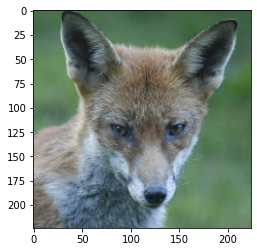

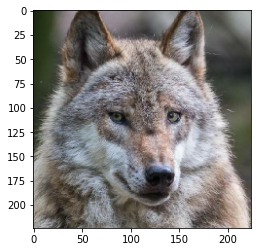

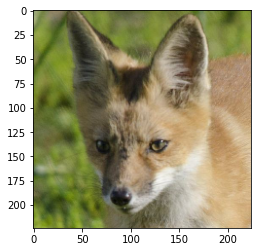

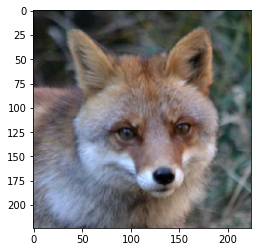

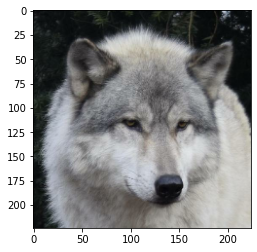

In [14]:
import matplotlib.pyplot as plt

def plot_lable(db,query_labels):
  count = 0 
  for i,lable in enumerate(db.labels_):
    if lable == query_labels and count < 5:
      plt.imshow(decode_image(PATHS[i]))
      plt.show()
      count+=1
    elif count>5:
      break
plot_lable(db,1)
    

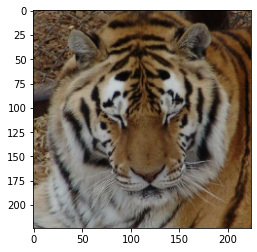

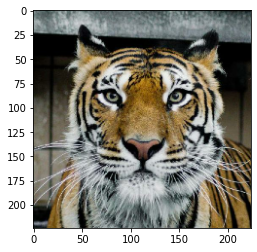

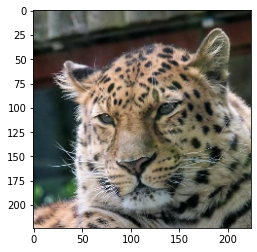

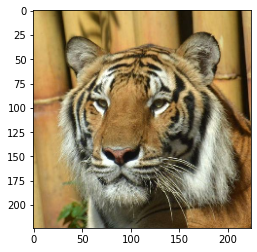

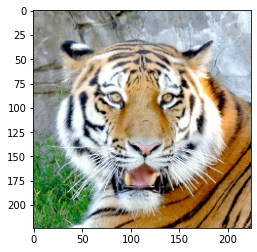

In [15]:
plot_lable(db,0)

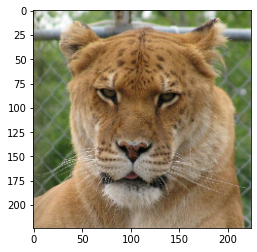

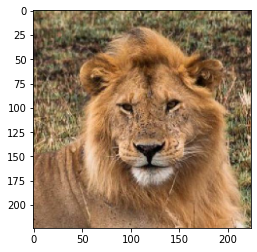

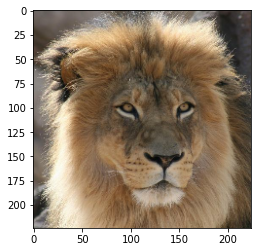

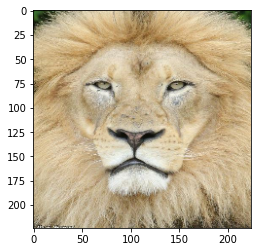

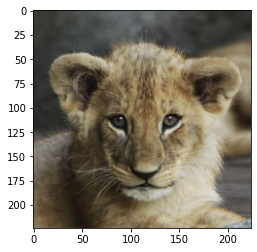

In [16]:
plot_lable(db,2)

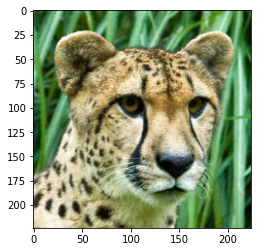

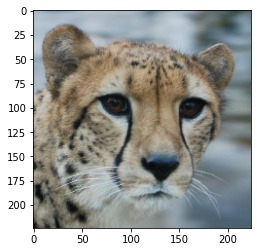

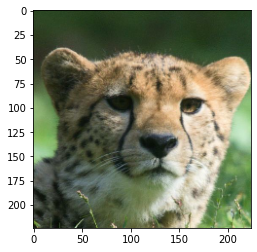

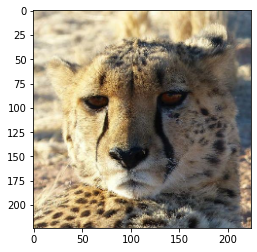

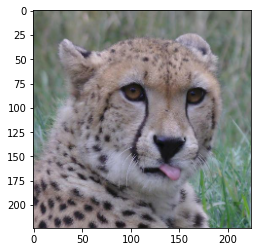

In [17]:
plot_lable(db,3)

now the noise images. that is the images our algo cannot attach to any cluster.

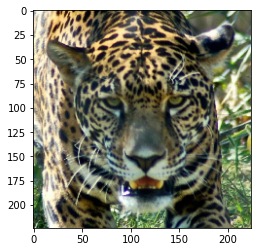

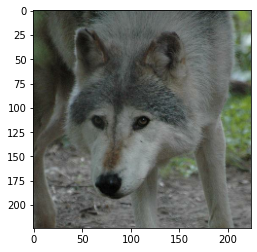

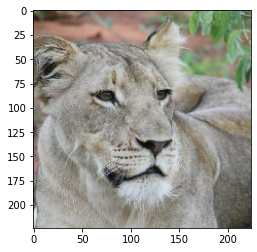

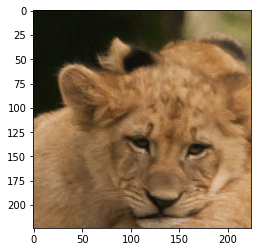

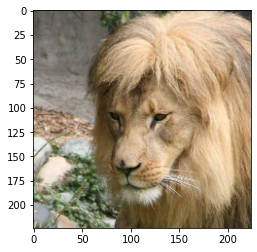

In [19]:
plot_lable(db,-1)